<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-data-and-parameters" data-toc-modified-id="Import-data-and-parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data and parameters</a></span><ul class="toc-item"><li><span><a href="#Tuning-Parameters" data-toc-modified-id="Tuning-Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tuning Parameters</a></span></li></ul></li><li><span><a href="#System-initialization" data-toc-modified-id="System-initialization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>System initialization</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Scenario-parameters" data-toc-modified-id="Scenario-parameters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Scenario parameters</a></span></li><li><span><a href="#Simulation-main" data-toc-modified-id="Simulation-main-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulation main</a></span></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Save results</a></span></li><li><span><a href="#Price-evolution" data-toc-modified-id="Price-evolution-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Price evolution</a></span></li><li><span><a href="#Supply-and-demand-evolution" data-toc-modified-id="Supply-and-demand-evolution-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Supply and demand evolution</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
idx = pd.IndexSlice
import random 
from scipy import stats

from mine_simulation_tools_closing_variant import *
from refinery import *
from scrap_supply_tools import *
from demand_tools import *
from price_formation import *

ModuleNotFoundError: No module named 'mine_simulation_tools_closing_variant'

# Import data and parameters

In [2]:
## High level parameters
historical_prod=pd.read_excel('Data/Production data compile.xlsx', sheet_name='Selected', index_col=0)
historical_price=pd.read_excel('Data/Price data compile.xlsx', sheet_name='Price', index_col=0) # All prices 2017 constant

# Specific prod and mine data
historical_mining_prod=historical_prod.loc[:, 'Total mining production']
historical_lme_price=historical_price.loc[:, 'LME']
historical_tcrc=historical_price.loc[:, 'Annual TCRC']
historical_no2=historical_price.loc[:, 'No.2 ref']
historical_sp2=historical_lme_price-historical_no2


## Primary supply data and parameters
# operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool.xls', sheet_name='Sheet1', index_col=0)
# open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter.xlsx', sheet_name='Sheet1', index_col=0)

operating_mine_pool=pd.read_excel('Data/primary supply/Operating mine pool max.xls', sheet_name='Sheet1', index_col=0)
open_parameter=pd.read_excel('Data/primary supply/Opening subsample parameter low max.xlsx', sheet_name='max5', index_col=0)

incentive_pool=pd.read_excel('Data/primary supply/Incentive mine pool.xls', sheet_name='Sheet1', index_col=0)
pri_hyper_param=pd.read_excel('Data/primary supply/Hyperparameters.xlsx', sheet_name='Sheet1', index_col=0)


## Refinery parameters
ref_hyper_param=pd.read_excel('Data/refined supply/Refinery hyperparameter.xlsx', sheet_name='Parameters', index_col=0)
conc_to_cathode_eff=ref_hyper_param.loc['conc to cathode eff', 'Value']
scrap_to_cathode_eff=ref_hyper_param.loc['scrap to cathode eff', 'Value']


## Semis demand parameters
gdp_growth_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='GDP growth', index_col=0, usecols=np.arange(6))
volume_prediction_base=pd.read_excel('Data/semis demand/Demand prediction data.xlsx', sheet_name='All sectors', index_col=0, header=[0,1])
intensity_prediction=pd.read_excel('Data/semis demand/Intensity initial.xls', sheet_name='Sheet1', index_col=0, header=[0,1])
elas_sec_reg=pd.read_excel('Data/semis demand/Elasticity estimates.xlsx', sheet_name='S+R S intercept only', index_col=0)
sector_shape_matrix=pd.read_excel('Data/semis demand/Sector to shape matrix.xlsx', sheet_name='Sheet1', index_col=0)
calibration_1718=pd.read_excel('Data/semis demand/2017 and 2018 calibration.xlsx', sheet_name='Sheet1', index_col=0)

# Adjust demand in 2018 to scale it back to ICSG
intensity_prediction.loc[2017, :] = intensity_prediction.loc[2017, :]\
.mul(calibration_1718.loc[2017, 'ICSG refined usage']).div(calibration_1718.loc[2017, 'simulated refined usage'])
intensity_prediction.loc[2018, :] = intensity_prediction.loc[2018, :]\
.mul(calibration_1718.loc[2018, 'ICSG refined usage']).div(calibration_1718.loc[2018, 'simulated refined usage'])
demand_prediction=volume_prediction_base.loc[2015:, :].mul(intensity_prediction.fillna(0))


## Scrap supply parameters
use_sector_combined=pd.read_excel('Data/scrap supply/End use combined data.xlsx', sheet_name='Combined', index_col=0)
sector_to_product=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='sector to product', index_col=0)
product_to_waste=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to waste', index_col=0)
product_life_and_eff=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product lifetime and efficiency', index_col=0)
product_to_cathode_alloy=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='product to copper or alloy', index_col=0)
recycle_efficiency=pd.read_excel('Data/scrap supply/All accounting matrix.xlsx', sheet_name='recycling efficiency', index_col=0)

# Home scrap ratio
home_scrap_ratio_file=pd.read_excel('Data/scrap supply/Home scrap ratio.xls', sheet_name='Sheet1', index_col=0)
home_scrap_ratio_series=home_scrap_ratio_file.loc[:, 'Ratio']
exchange_scrap_ratio_series=0.9-home_scrap_ratio_series

# Sector end use to product matrix 
use_product_history=pd.DataFrame(np.matmul(use_sector_combined, sector_to_product.transpose()), 
                                 index=use_sector_combined.index, columns=sector_to_product.index)
# Product to waste matrices
product_to_waste_collectable=product_to_waste.iloc[:, :-2]
product_to_waste_no_loss=product_to_waste_collectable.mul(1/product_to_waste_collectable.sum(axis=1), axis=0)

# Product lifetime parameters and frequencies
product_lifetime=product_life_and_eff.loc[:, 'Lifetime']
product_lifetime_df=lifetime_df(product_lifetime)
product_lifetime_freq_df=lifetime_freq_df(product_lifetime_df)

# Recycling and fabrication efficiencies
sort_eff=recycle_efficiency.iloc[:, 0]
collect_rate=recycle_efficiency.iloc[:, 1]
fab_eff=product_life_and_eff.loc[:, 'Fabrication efficiency']
new_scrap_gen=1/fab_eff-1


## Price formation parameters
price_formation_param=pd.read_excel('Data/price formation/Price formation.xlsx', sheet_name='Sheet1', index_col=0)
cathode_sd_elas=price_formation_param.loc['Cathode SD elasticity', 'Value']
conc_sd_elas=price_formation_param.loc['Concentrate SD elasticity', 'Value']
cathode_sp2_elas=price_formation_param.loc['SP2 cathode elasticity', 'Value']
sp2_sd_elas=price_formation_param.loc['SP2 SD elasticity', 'Value']

## Tuning Parameters

In [41]:
ref_hyper_param

,Value,Description
Item,,
pri cap,7470.609912,Calculated primary capacity
pri CU,0.860051,2018 Capacity utilization rate of all refineri...
pri CU TCRC elas,0.057419,Primary CU long run elasticity to TCRC
sec cap,15426.642911,Calculated secondary capacity
sec CU,0.860051,2018 Capacity utilization rate of all refineri...
sec CU TCRC elas,0.152867,Secondary CU long run elasticity to TCRC
sec ratio,0.325000,Simulated sec ratio based on 2016 initial data
sec ratio TCRC elas,-0.197009,Secondary ratio long run elasticity to TCRC
sec ratio SP2 elas,0.315688,Secondary ratio long run elasticity to No.2 sp...


1. **sec_coef**, describes to what extent secondary refinery capacity growth follows scrap supply
2. **open_parameter**, how many mines to assess for opening possibility
3. **sp2_sd_elas**, The elasticity of SP2 (spread for No 2 scrap?) to scrap S-D. This is not estimated through regression, value just assigned

Those below should probably be modified in the cell above, since they are used in System Initialization
4. **new_scrap_gen**, for new scrap generation rate (computed from fabrication efficiency **fab_eff**)
5. **product_life_and_eff**, for product lifetimes and fabrication efficiencies
6. **product_to_waste_collectable**, for waste collection rates
7. **home_scrap_ratio_file**, gives ratio of scrap that is home scrap
8. **use_product_history**, gives end use by product statistics for every year
9. **recycle_efficiency**, the sorting efficiency and end-of-life collection rate
10. **ref_hyper_param**, refinery hyperparameters

# System initialization

In [3]:
# Initialize simulation time
history_start_time='19600101'
simulation_start_time='20180101'
simulation_end_time='20400101'
simulation_time=pd.date_range(simulation_start_time, simulation_end_time, freq='AS')
history_time=pd.date_range(history_start_time, simulation_start_time, freq='AS')

# Cathode price
cathode_price_series=pd.Series(0, index=history_time)
cathode_price_series.loc[:'20180101']=historical_lme_price.values

# TCRC
tcrc_series=pd.Series(0, index=history_time)
tcrc_series.loc[:'20180101']=historical_tcrc.values

# No.2 scrap spread
sp2_series=pd.Series(0, index=history_time)
sp2_series.loc[:'20180101']=historical_sp2.values

# Initialize mining stats
mine_life_stats_panel_operating=mine_life_stats_panel_init(simulation_time, operating_mine_pool)
mine_pool_new_last=pd.DataFrame()
mine_life_stats_panel_new_last=pd.DataFrame()
total_mining_prod=pd.Series(0, index=simulation_time)

# Initilize sxew ids
sxew_id_operating_bool=operating_mine_pool.loc[:, 'Payable percent (%)']==100
sxew_id_operating=[i for i in sxew_id_operating_bool.index if sxew_id_operating_bool.loc[i]]
sxew_id_new_bool=incentive_pool.loc[:, 'Payable percent (%)']==100
sxew_id_new=[i for i in sxew_id_new_bool.index if sxew_id_new_bool.loc[i]]
sxew_new=pd.Series(0, index=simulation_time)
sxew_all=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
sxew_all.loc['20170101']=historical_prod.loc[2017, 'SX-EW production']

# Initialize refinery stats
ref_stats=ref_stats_init(simulation_time, ref_hyper_param)

# Initialize concentrate prod, add 2017
conc_prod_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
conc_prod_series.loc['20170101']=historical_prod.loc[2017, 'Concentrate production']

# Initialize refined supply and demand
ref_prod_series=pd.Series(0, index=simulation_time)
ref_demand_series=pd.Series(0, index=pd.date_range('20170101', simulation_end_time, freq='AS'))
ref_demand_series.loc['20170101']=historical_prod.loc[2017, 'Refined usage']

# Initialize end use by product stats
use_product_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=use_product_history.columns)
use_product_all_life=pd.concat([use_product_history, use_product_future])

# Initialize old scrap history
product_eol_history=product_reach_eol(use_product_history, product_lifetime_freq_df)
waste_from_old_history=pd.DataFrame(np.matmul(product_eol_history, product_to_waste_collectable), 
                                     index=product_eol_history.index, 
                                     columns=product_to_waste_collectable.columns).mul(sort_eff).mul(collect_rate)

waste_from_old_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_old_all_life=pd.concat([waste_from_old_history, waste_from_old_future])

# Initialize old scrap history
waste_from_new_history=pd.DataFrame(0, index=waste_from_old_history.index, columns=product_to_waste_collectable.columns)
for year_i in waste_from_new_history.index:
    home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
    exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
    waste_from_new_year_i=\
    simulate_new_scrap_one_year(year_i, use_product_history, new_scrap_gen, product_to_waste_no_loss, sort_eff, 
                                home_scrap_ratio, exchange_scrap_ratio)
    waste_from_new_history.loc[year_i]=waste_from_new_year_i.values

waste_from_new_future=pd.DataFrame(0, index=np.arange(2019, 2041, 1), columns=product_to_waste_collectable.columns)
waste_from_new_all_life=pd.concat([waste_from_new_history, waste_from_new_future])

waste_all_life=waste_from_old_all_life+waste_from_new_all_life

# Initialize scrap demand
direct_melt_scrap_demand=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1)
refined_scrap_demand=historical_prod.loc[:, 'Secondary refining production'].div(scrap_to_cathode_eff)
total_scrap_demand_all_life=pd.DataFrame({'Direct melt scrap': direct_melt_scrap_demand, 
                                          'Refined scrap': refined_scrap_demand})


# Simulation

Some tuning parameters
1. **sec_coef**, describes to what extent secondary refinery capacity growth follows scrap supply
2. **open_parameter**, how many mines to assess for opening possibility
3. **sp2_sd_elas**, The elasticity of SP2 to scrap S-D. This is not estimated through regression, value just assigned

## Scenario parameters

Scenario max_5_10: 
1. Closing method is max, closing year is 5
2. efficiency rise 10% in 2019

In [4]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sort_eff_series.loc[2019, :]+=0.1
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=5

Scenario max_5_01: 
1. Closing method is max, closing year is 5
2. efficiency rise 0.1% in 2019

In [39]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sort_eff_series.loc[2019, :]+=0.001
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=5

Scenario low_sp_elas_sm: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845/2
3. efficiency rise 1e-7 in 2019

In [47]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sort_eff_series.loc[2019, :]+=1e-7
sp2_sd_elas=0.0845/2
close_price_method='max'
close_years_back=5

Scenario min_sp_elas_sm: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845/4
3. efficiency rise 1e-7 in 2019

In [52]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sort_eff_series.loc[2019, :]+=1e-7
sp2_sd_elas=0.0845/4
close_price_method='max'
close_years_back=5

Scenario min_sp_elas_10: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845/4
3. efficiency rise 10% in 2019

In [57]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sec_coef=0
sort_eff_series.loc[2019, :]+=0.1
sp2_sd_elas=0.0845/4
close_price_method='max'
close_years_back=5

Scenario high_sre_sm: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845
3. Second ratio elasticity to TCRC and spread doubles
4. efficiency rise 1e-7 in 2019

In [62]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=1e-7
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=5
ref_hyper_param.loc['sec ratio TCRC elas']=-0.197009*2
ref_hyper_param.loc['sec ratio SP2 elas']=0.315688*2

Scenario high_cue_sm: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845
3. Ref CU elasticity to TCRC doubles (both pri and sec)
4. efficiency rise 1e-7 in 2019

In [67]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=1e-7
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=5
ref_hyper_param.loc['pri CU TCRC elas']=0.057419*2
ref_hyper_param.loc['sec CU TCRC elas']=0.152867*2

Scenario high_pse_sm: 
1. Closing method is max, closing year is 5
2. sp2_sd_elas=0.0845
3. Production short run elasticity doubles
4. efficiency rise 1e-7 in 2019

In [72]:
sort_eff_series=pd.DataFrame(np.array((list(sort_eff)*23)).reshape(23, 6), index=np.arange(2018, 2041), columns=sort_eff.index)
sort_eff_series.loc[2019, :]+=1e-7
sec_coef=0
sp2_sd_elas=0.0845
close_price_method='max'
close_years_back=5
pri_hyper_param.loc['Production elasticity']=0.024*2

## Simulation main

In [5]:
for year_i in np.arange(2018, 2041):
    
    print(year_i)
    t=datetime(year_i, 1, 1)
    t_lag_1=datetime(year_i-1, 1, 1)
    t_lag_2=datetime(year_i-2, 1, 1)
    
    #### Scenario parameters ####
    sort_eff=sort_eff_series.loc[year_i]
    
    #### Price formation ####
    if year_i > 2018:        
        ### Cathode price ###
        cathode_bal_l1=ref_prod_series.loc[t_lag_1]-ref_demand_series.loc[t_lag_1]
        cathode_price_series.loc[t]=cathode_price_predict(cathode_price_series.loc[t_lag_1], 
                                                          cathode_balance=cathode_bal_l1, cathode_sd_elas=cathode_sd_elas)

        ### TCRC ###
        conc_bal_l1=conc_prod_series.loc[t_lag_1]-ref_stats.loc[t_lag_1, 'Primary production']/conc_to_cathode_eff
        tcrc_series.loc[t]=tcrc_predict(tcrc_series.loc[t_lag_1], 
                                        conc_balance=conc_bal_l1, conc_sd_elas=conc_sd_elas)
        
        ### SP2 ###
        scrap_bal_l1=waste_all_life.sum(axis=1).loc[year_i-1]-total_scrap_demand_all_life.sum(axis=1).loc[year_i-1]
        cathode_price_diff=cathode_price_series.loc[t]-cathode_price_series.loc[t_lag_1]
        sp2_series.loc[t]=sp2_predict(sp2_series.loc[t_lag_1], 
                                      scrap_balance=scrap_bal_l1, scrap_sd_elas=sp2_sd_elas, 
                                      cathode_diff=cathode_price_diff, cathode_sp2_elas=cathode_sp2_elas)
                
    # TCRC to cents per pound
    tcrc_cpp_series = tcrc_series.copy().div(22.0462)

 
    #### Production of operating mine ####
    for mine_id in operating_mine_pool.index:
        mine_data = operating_mine_pool.loc[mine_id]
        mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, 2018, 
                                                         mine_life_stats_panel_operating, mine_data, 
                                                         cathode_price_series, tcrc_cpp_series, pri_hyper_param,
                                                         close_price_method, close_years_back)
        mine_life_stats_panel_operating.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values

    # Total production statistics
    prod_operating=mine_life_stats_panel_operating.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
    sxew_operating=mine_life_stats_panel_operating.loc[:, idx[sxew_id_operating, 'Recovered metal production (kt)']].sum(axis=1)
    conc_operating=prod_operating-sxew_operating
    
    
    #### Production of new mines ####
    if year_i > 2018:
        # Read subsample size parameter and generate new incentive pool for year_i
        subsample_size=open_parameter.loc[year_i, 'Subsample size']
        mine_pool_new_year_i=new_mine_data(year_i, simulation_end_time, incentive_pool, cathode_price_series, 
                                           pri_hyper_param, subsample_size, 0.15,
                                           close_price_method, close_years_back)
        print('New mines opening this year: ', mine_pool_new_year_i.shape[0])
      
        # Initialize mine life panel data for incentive pool year_i
        mine_life_stats_panel_new_year_i=mine_life_stats_panel_init(simulation_time, mine_pool_new_year_i)
      
        # Append new incentive pool at year_i
        mine_pool_new=pd.concat([mine_pool_new_last, mine_pool_new_year_i])
        mine_life_stats_panel_new=pd.concat([mine_life_stats_panel_new_last, mine_life_stats_panel_new_year_i], axis=1)
        
        for mine_id in mine_pool_new.index:
            mine_data = mine_pool_new.loc[mine_id]
            mine_life_stats = simulate_mine_life_stats_panel(simulation_time, year_i, mine_data.loc['Initial year'], 
                                                             mine_life_stats_panel_new, mine_data, 
                                                             cathode_price_series, tcrc_cpp_series, pri_hyper_param, 
                                                             close_price_method, close_years_back)
            mine_life_stats_panel_new.loc[:, idx[mine_id, :]]=mine_life_stats.loc[simulation_time, :].values
        
        
        # Total production statistics
        prod_new=mine_life_stats_panel_new.loc[:, idx[:, 'Recovered metal production (kt)']].sum(axis=1)
        sxew_new=mine_life_stats_panel_new.loc[:, idx[sxew_id_new, 'Recovered metal production (kt)']].sum(axis=1)
        conc_new=prod_new-sxew_new
        
        # Update incentive pool info
        mine_pool_new_last=mine_pool_new.copy()
        mine_life_stats_panel_new_last=mine_life_stats_panel_new.copy()

        
    #### Update total mining production ####
    if year_i == 2018:
        conc_new=pd.Series(0, index=simulation_time)
        prod_new=pd.Series(0, index=simulation_time)
        
    conc_prod_series.loc[t]=conc_operating.loc[t]+conc_new.loc[t]
    sxew_all.loc[t]=sxew_operating.loc[t]+sxew_new.loc[t]
    print('Total mining production: ', prod_operating.loc[t]+prod_new.loc[t])
    
    
    #### Demand for refined copper ####
    if year_i == 2018:
        pass
    else:
        intensity_next=intensity_prediction_one_year(year_i, cathode_price_series, gdp_growth_prediction_base, 
                                                     intensity_prediction.loc[year_i-1, :], volume_prediction_base, 
                                                     elas_sec_reg, method='sec and reg')
        intensity_prediction.loc[year_i, :]=intensity_next.values
        demand_prediction.loc[year_i, :]=intensity_prediction.loc[year_i, :].mul(volume_prediction_base.loc[year_i, :]).values
    
    # Demand by shape and refined copper demand
    demand_by_sector=demand_prediction.groupby(level=0, axis=1).sum()
    demand_by_shape=pd.DataFrame(np.matmul(demand_by_sector, sector_shape_matrix.transpose()), 
                                 index=demand_by_sector.index, columns=sector_shape_matrix.index)
    ref_demand_series.loc[t]=demand_by_shape.loc[year_i, 'Copper']
    
    
    #### Production of refineries ####
    if year_i == 2018:
        pass
    else:
        ref_stats_next=simulate_refinery_production_oneyear(year_i, tcrc_series, sp2_series, 
                                                            ref_demand_series, waste_all_life.sum(axis=1),
                                                            ref_stats, ref_hyper_param, 
                                                            sec_coef=sec_coef, growth_lag=1)
        ref_stats.loc[t, :]=ref_stats_next
    
    total_ref_prod=ref_stats.loc[t, 'Primary production']+ref_stats.loc[t, 'Secondary production']+sxew_all.loc[t]
    ref_prod_series.loc[t]=total_ref_prod

    
    #### Generation of old scrap ####
    if year_i > 2018:
        # Calculate end use by sector and by product
        use_sector_year_i=demand_prediction.groupby(level=0, axis=1).sum()\
                          .loc[:, list(sector_to_product.columns)].loc[year_i, :]
        use_product_year_i=pd.Series(np.matmul(use_sector_year_i, sector_to_product.transpose()), 
                                     index=sector_to_product.index)
        use_product_all_life.loc[year_i]=use_product_year_i.values
        
        # Product reaching end of life and waste collected
        product_eol_year_i=product_reach_eol_oneyear(year_i, use_product_all_life, product_lifetime_freq_df)
        waste_collected_year_i=waste_collected_oneyear(product_eol_year_i, product_to_waste_collectable, sort_eff, collect_rate)
        waste_from_old_future.loc[year_i]=waste_collected_year_i

        
    #### Generation of new scrap ####
    if year_i > 2018:
        home_scrap_ratio=home_scrap_ratio_series.loc[year_i]
        exchange_scrap_ratio=exchange_scrap_ratio_series.loc[year_i]
        waste_from_new_year_i=\
        simulate_new_scrap_one_year(year_i, use_product_all_life, new_scrap_gen, product_to_waste_no_loss, sort_eff,
                                    home_scrap_ratio, exchange_scrap_ratio)
        waste_from_new_future.loc[year_i]=waste_from_new_year_i
    
        # All scrap
        waste_all_life.loc[year_i]=waste_from_new_year_i+waste_collected_year_i
    
    print('Total scrap supply: ', waste_all_life.sum(axis=1).loc[year_i])
    
    
    #### Demand of scrap
    direct_melt_scrap_demand_year_i=use_product_all_life.mul(product_to_cathode_alloy.loc[:, 'Alloyed']).sum(axis=1).loc[year_i]
    refined_scrap_demand_year_i=ref_stats.loc[t, 'Secondary production']/scrap_to_cathode_eff
    total_scrap_demand_all_life.loc[year_i, 'Direct melt scrap']=direct_melt_scrap_demand_year_i
    total_scrap_demand_all_life.loc[year_i, 'Refined scrap']=refined_scrap_demand_year_i
    

2018
Total mining production:  20530.901667342747
Total scrap supply:  10967.168860009264
2019
New mines opening this year:  143
Total mining production:  20348.313536204972
Total scrap supply:  12380.990596362286
2020
New mines opening this year:  0
Total mining production:  21317.649244230593
Total scrap supply:  11327.730305133913
2021
New mines opening this year:  47
Total mining production:  21197.12320161768
Total scrap supply:  11526.082709596498
2022
New mines opening this year:  15
Total mining production:  21582.725750689053
Total scrap supply:  11741.431822388982
2023
New mines opening this year:  42
Total mining production:  21369.598897522577
Total scrap supply:  11964.121604179953
2024
New mines opening this year:  29
Total mining production:  21593.38814759524
Total scrap supply:  12190.546928192765
2025
New mines opening this year:  42
Total mining production:  21826.322138129304
Total scrap supply:  12412.938810934
2026
New mines opening this year:  24
Total mining pro

## Save results

In [10]:
prices_simulated=pd.DataFrame({'Cathode': cathode_price_series, 'No.2 spread': sp2_series, 'TCRC': tcrc_series})
# prices_simulated.to_excel('Data/scenario results/simulated price high_pse_sm.xls')

mining_prod_df_future=pd.concat([conc_operating+conc_new, sxew_operating+sxew_new], axis=1)
mining_prod_df_future.columns=['Concentrate production', 'SX-EW production']
mining_prod_df_history=historical_prod.loc[:, ['Concentrate production', 'SX-EW production']].iloc[:-1, :]
mining_prod_df_history.index=pd.date_range('19500101', '20170101', freq='AS')
mining_prod_df_all=pd.concat([mining_prod_df_history, mining_prod_df_future])

conc_demand_history=pd.Series(historical_prod.loc[1950:, 'Primary refining production'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS')).div(0.99)
conc_demand_all=pd.concat([conc_demand_history.loc[:'20170101'], ref_stats.loc[:, 'Primary production'].div(0.99)])
conc_demand_all.name='Concentrate demand'


ref_prod_df_history=\
historical_prod.loc[:, ['Primary refining production', 'Secondary refining production', 'SX-EW production']].iloc[10:-1, :]
ref_prod_df_history.index=pd.date_range('19600101', '20170101', freq='AS')
ref_prod_df_future=pd.concat([ref_stats.loc[:, ['Primary production', 'Secondary production']], sxew_all.iloc[1:]], axis=1)
ref_prod_df_future.columns=ref_prod_df_history.columns
ref_prod_df_all=pd.concat([ref_prod_df_history, ref_prod_df_future])

ref_demand_history=pd.Series(historical_prod.loc[1950:, 'Refined usage'].values, 
                              index=pd.date_range('19500101', '20180101', freq='AS'))
ref_demand_all=pd.concat([ref_demand_history, ref_demand_series.loc['20190101':]])
ref_demand_all.name='Refined demand'


scrap_supply=waste_all_life.loc[1950:].sum(axis=1)
scrap_supply.index=pd.date_range('19500101', '20400101', freq='AS')
scrap_supply.name='Scrap production'

scrap_demand=total_scrap_demand_all_life.loc[1950:, :]
scrap_demand.index=pd.date_range('19500101', '20400101', freq='AS')\

sd_simulated=pd.concat([mining_prod_df_all, conc_demand_all, ref_prod_df_all, ref_demand_all, scrap_supply, scrap_demand],axis=1)
# sd_simulated.to_excel('Data/scenario results/simulated supply and demand high_pse_sm.xls')

## Price evolution

<IPython.core.display.Javascript object>


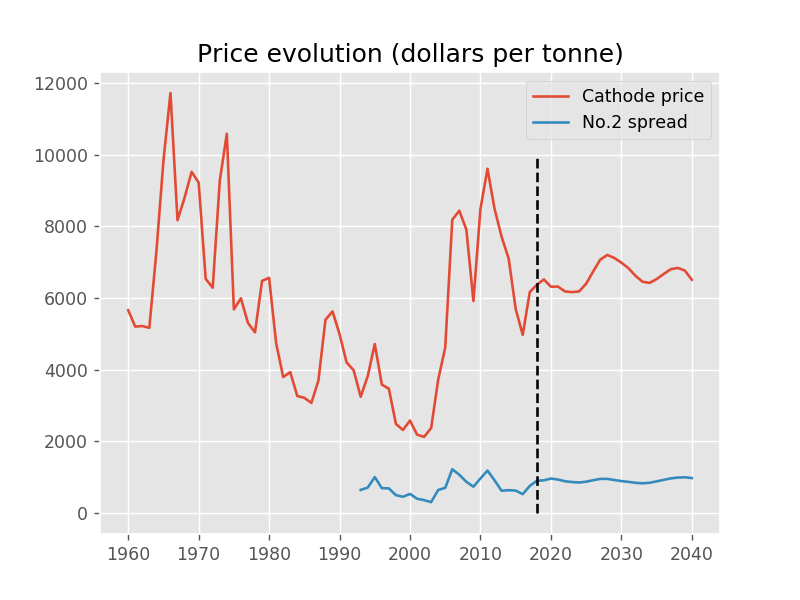

In [11]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(cathode_price_series, label='Cathode price')
plt.plot(sp2_series, label='No.2 spread')
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [0, 10000], 'k--')

plt.legend()
plt.title('Price evolution (dollars per tonne)')
plt.show()


In [7]:
# No.2 spread and cathode price correlation
print(sp2_series.diff().loc[:'20180101'].corr(cathode_price_series.diff().loc[:'20180101']))
print(sp2_series.diff().loc['20190101':].corr(cathode_price_series.diff().loc['20190101':]))

0.8490678763866732
0.6259824101448843


<IPython.core.display.Javascript object>


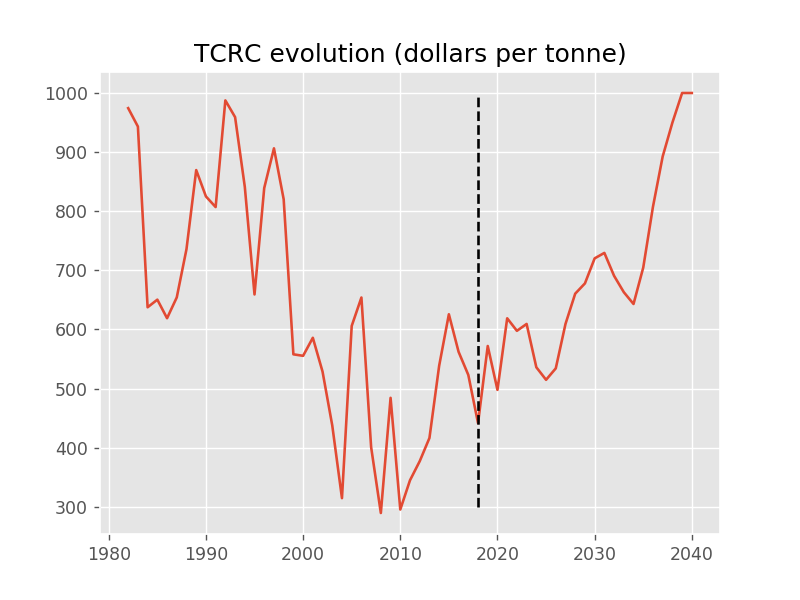

In [12]:
%matplotlib notebook
plt.style.use('ggplot')
plt.plot(tcrc_series)
plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [300, 1000], 'k--')
plt.title('TCRC evolution (dollars per tonne)')
plt.show()


## Supply and demand evolution

<IPython.core.display.Javascript object>


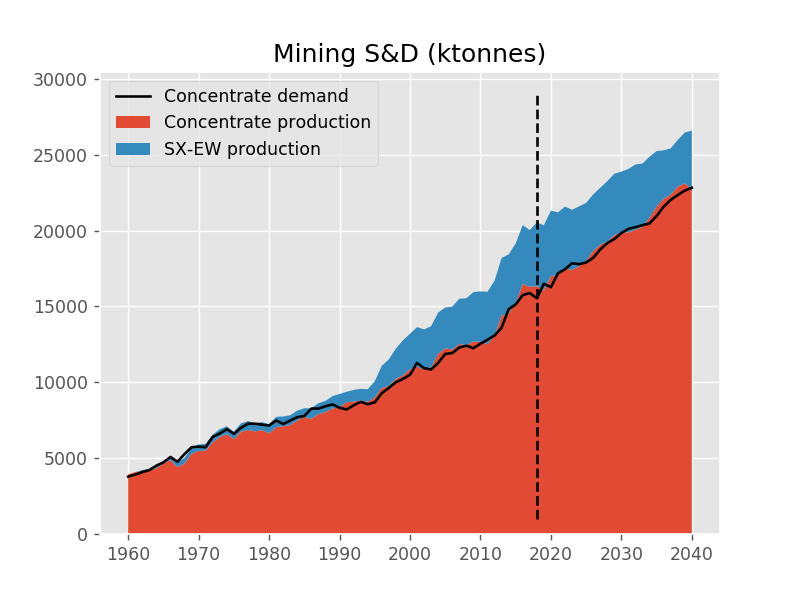

In [13]:
%matplotlib notebook
plt.stackplot(mining_prod_df_all.loc['19600101':, :].index, mining_prod_df_all.loc['19600101':, :].transpose(), 
              labels=mining_prod_df_all.columns)
plt.plot(conc_demand_all, 'k', label='Concentrate demand')

plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 29000], 'k--')
plt.legend(loc=2)
plt.title('Mining S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


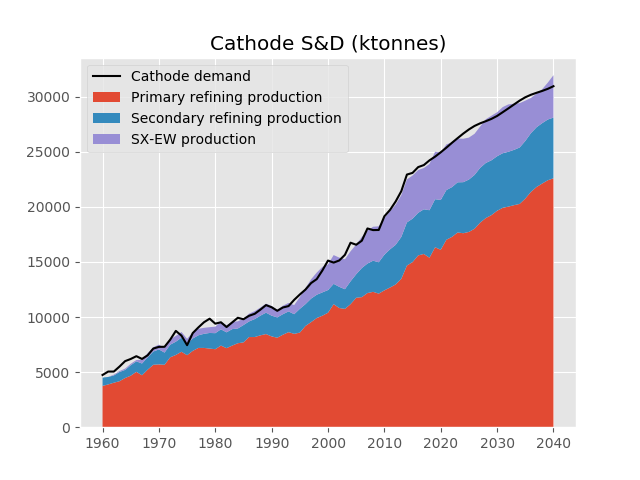

In [31]:
%matplotlib notebook
plt.stackplot(ref_prod_df_all.index, ref_prod_df_all.transpose(), 
              labels=ref_prod_df_all.columns)
plt.plot(ref_demand_all, 'k', label='Cathode demand')

# plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [1000, 34000], 'k--')
plt.legend(loc=2)
plt.title('Cathode S&D (ktonnes)')
plt.show()

<IPython.core.display.Javascript object>


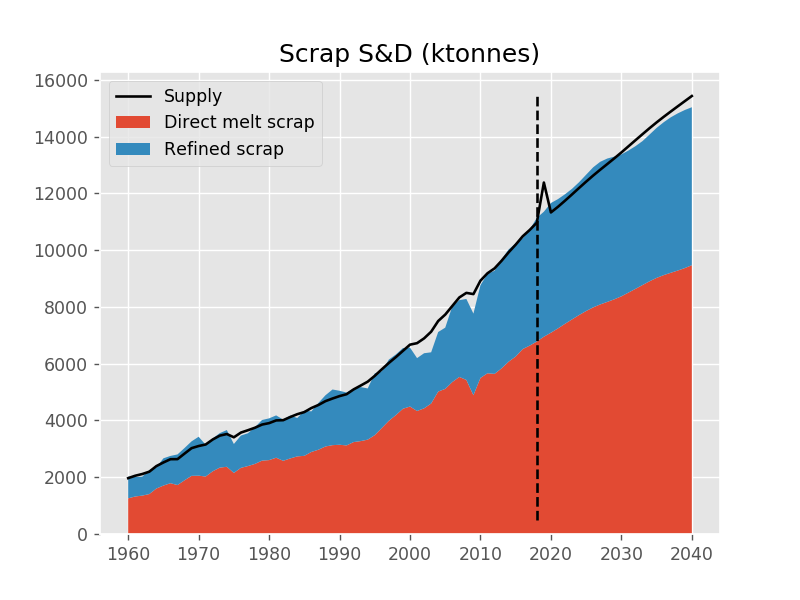

In [14]:
%matplotlib notebook
plt.plot(scrap_supply.loc['19600101':], 'k', label='Supply')
plt.stackplot(scrap_demand.loc['19600101':, :].index, scrap_demand.loc['19600101':, :].transpose(), 
              labels=scrap_demand.columns)

plt.plot([datetime(2018,1,1), datetime(2018,1,1)], [500, 15500], 'k--')
plt.title('Scrap S&D (ktonnes)')
plt.legend()
plt.show()